# Linear Regression

In [2]:
#imports

import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso , Ridge , LinearRegression
from sklearn.preprocessing import PolynomialFeatures , StandardScaler , OneHotEncoder , OrdinalEncoder

In [3]:
# constants
username = "shubham.goel"
num_of_students = 10000
seed = int ( hashlib.sha256(username.encode()).hexdigest(),16)%(2**32)
print(seed)

3029262140


In [4]:
# StudentDataset class

class STUDENT_DATASET:
    def __init__(self , num_students : int , seed : int):
        ''' Generates the full dataset during initialization using the specified number of students and seed.'''
        self.num_students = num_students
        self.rng = np.random.default_rng(seed)
        self.df = self.assemble_dataframes()
        

    def get_full_dataframe(self):
        """returns the pandas dataframe for the full dataset"""
        return self.df
        

    def generate_gender(self):
        """generates the genders acc to the given prob distribution"""
        genders = ["Male" , "Female" ,"Other"]
        probs =  [0.65 ,0.33,0.02]
        return self.rng.choice(genders , size =self.num_students ,p =  probs).tolist()
        

    def generate_major(self):
        """generates the Majors acc to the given prob distribution"""
        majors= ["B.Tech","MS","PHD"]
        probs =[0.70,0.20,0.10]
        return self.rng.choice(majors , self.num_students , p  = probs)

        

    def generate_program(self , majors:list[str])->list[str]:
        """generates the programs corresponding to majors"""
        programs = []
        p = ["CSE", "ECE", "CHD", "CND"]
        for m in majors:
            if m == "B.Tech":
                probs = [0.40, 0.40, 0.10, 0.10]
            elif m == "MS":
                
                probs = [0.30, 0.30, 0.20, 0.20]
            elif m == "PHD":
                 
                 probs = [0.25, 0.25, 0.25, 0.25]

            programs.append(self.rng.choice(p , p  = probs))
        return programs

    def generate_gpa(self ,majors : list[str])->list[float]:
        """generates gpas according to majors"""
        gpas = []
        for m in majors:
            if m == "B.Tech":
                g = self.rng.normal(7.0,1.0)
            elif m == "PHD":
                g = self.rng.normal(8.0,0.7)

            elif m == "MS":
                g = self.rng.normal(8.3,0.5)

            g = np.clip(g,4.0,10.0)
            gpas.append(round(float(g),2))
        return gpas

    def assemble_dataframes(self):
        genders = self.generate_gender()
        majors = self.generate_major()
        programs = self.generate_program(majors)
        gpas = self.generate_gpa(majors)

        df   = pd.DataFrame({
            "Gender": genders,
            "Major": majors,
            "Program": programs,
            "GPA": gpas
        })
        return df


In [5]:
class PerFeatureTransformer:
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        self.transformers = {}
        self.params = None
        self.fitted = False

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        """
        Fits transformers for each feature based on the given type.

        Parameters:
        df : The dataframe containing features to be transformed.
        params : A dictionary mapping feature name to transformation type,
        e.g., {"GPA": "standard", "Major": "ordinal", "Program": "onehot"}.
        """
        self.params = params
        for col, t_type in params.items():
            if t_type == "standard":
                scaler = StandardScaler()
                scaler.fit(df[[col]])
                self.transformers[col] = scaler
            elif t_type == "onehot":
                enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
                enc.fit(df[[col]])
                self.transformers[col] = enc
            elif t_type == "ordinal":
                enc = OrdinalEncoder()
                enc.fit(df[[col]])
                self.transformers[col] = enc
            else:
                raise ValueError(f"Unknown transformation type {t_type}")
        self.fitted = True

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """
        Applies the fitted transformers to the corresponding features and returns a NumPy array.
        """
        if not self.fitted:
            raise RuntimeError("Transformer not fitted yet.")

        transformed_features = []
        for col, t_type in self.params.items():
            transformer = self.transformers[col]
            arr = transformer.transform(df[[col]])
            transformed_features.append(arr)
        return np.hstack(transformed_features)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """
        Fits and transforms all features in one step using the given transformation parameters.
        """
        self.fit(df, params)
        return self.transform(df)

In [38]:
def run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                       degree=1, regularizer=None, reg_strength=0.0):
    """
    Fit a polynomial regression model with optional regularization.
    Parameters:
        degree (int): Degree of the polynomial to fit
        regularizer (str or None): 'l1', 'l2', or None
        reg_strength (float): Regularization coefficient (alpha)
    Returns:
        dict with train, val, and test MSEs, and learned coefficients
    """
    

    # Polynomial feature transformation
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    # Select model
    if regularizer == 'l1':
        model = Lasso(alpha=reg_strength, max_iter=10000)
    elif regularizer == 'l2':
        model = Ridge(alpha=reg_strength)
    else:
        model = LinearRegression()

    # Fit model
    model.fit(X_train_poly, y_train)

    # Predict
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    y_test_pred = model.predict(X_test_poly)

    # Compute MSEs
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Return results
    return {
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'coefficients': model.coef_,
        'intercept': model.intercept_
    }

In [39]:
dataset  = STUDENT_DATASET(num_students=num_of_students,seed=seed)
df = dataset.get_full_dataframe()

print(df.head())
print(df.describe())

   Gender   Major Program   GPA
0    Male      MS     CSE  8.37
1  Female  B.Tech     CHD  6.76
2    Male  B.Tech     ECE  8.86
3    Male  B.Tech     ECE  7.98
4    Male      MS     ECE  8.58
                GPA
count  10000.000000
mean       7.378310
std        1.048042
min        4.000000
25%        6.630000
50%        7.460000
75%        8.180000
max       10.000000


In [40]:
# Prepare features and target for regression
features = ["Major", "Program", "Gender"]
target = "GPA"

# Encode categorical features using PerFeatureTransformer
params = {
    "Major": "ordinal",
    "Program": "onehot",
    "Gender": "ordinal"
}
transformer = PerFeatureTransformer()
transformer.fit(df[features], params)

X = transformer.transform(df[features])
y = df[target].values

# Split into train, val, test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (6000, 6), Val shape: (2000, 6), Test shape: (2000, 6)


In [41]:


degrees = range(1, 7)
reg_strength_default = 0.01
setups = [
    {"name": "None", "regularizer": None, "reg_strength": 0.0},
    {"name": "L1", "regularizer": "l1", "reg_strength": reg_strength_default},
    {"name": "L2", "regularizer": "l2", "reg_strength": reg_strength_default}
 ]

results = {}
for setup in setups:
    train_mse_list = []
    val_mse_list = []
    for degree in degrees:
        res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                                  degree=degree,
                                  regularizer=setup["regularizer"],
                                  reg_strength=setup["reg_strength"])
        train_mse_list.append(res["train_mse"])
        val_mse_list.append(res["val_mse"])
    results[setup["name"]] = {"train_mse": train_mse_list, "val_mse": val_mse_list}

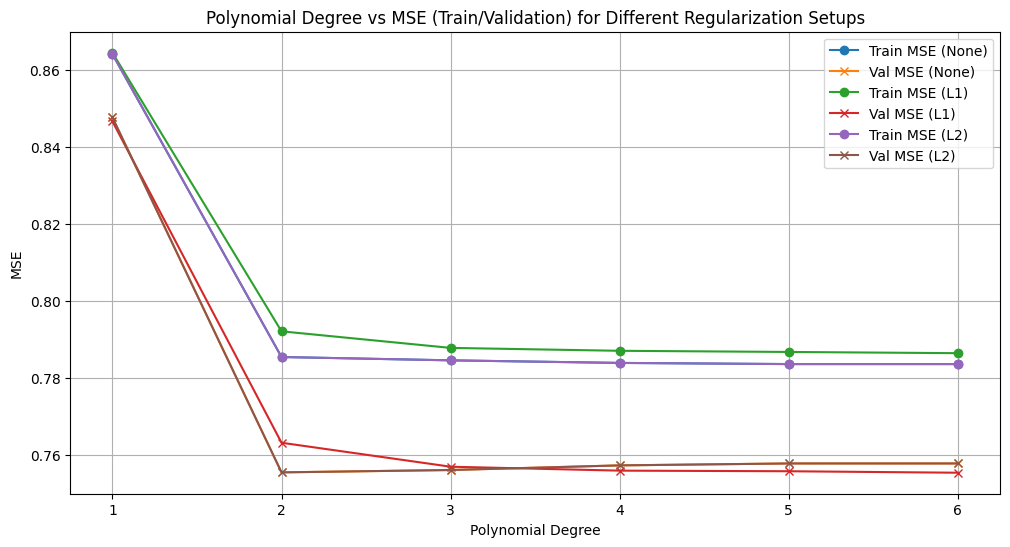

In [42]:
plt.figure(figsize=(12, 6))

for setup in setups:
    plt.plot(degrees, results[setup["name"]]["train_mse"], label=f"Train MSE ({setup['name']})", marker='o')
    plt.plot(degrees, results[setup["name"]]["val_mse"], label=f"Val MSE ({setup['name']})", marker='x')
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("Polynomial Degree vs MSE (Train/Validation) for Different Regularization Setups")
plt.legend()
plt.grid(True)
plt.show()

### Observed Trend: Degree vs MSE

As the polynomial degree increases, the training MSE typically decreases due to increased model flexibility. However, validation MSE may decrease initially and then increase for higher degrees, indicating overfitting. Regularization (L1/L2) helps control overfitting, resulting in lower validation MSE for higher degrees compared to no regularization.

In [1]:
reg_strengths = np.logspace(-4, 2, 10)
best_reg_strengths = {"L1": {}, "L2": {}}
best_val_mse = {"L1": {}, "L2": {}}

for reg_type in ["L1", "L2"]:
    for degree in degrees:
        val_mses = []
        for reg_strength in reg_strengths:
            res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                                      degree=degree,
                                      regularizer=reg_type.lower(),
                                      reg_strength=reg_strength)
            val_mses.append(res["val_mse"])
        min_idx = np.argmin(val_mses)
        best_reg_strengths[reg_type][degree] = reg_strengths[min_idx]
        best_val_mse[reg_type][degree] = val_mses[min_idx]

NameError: name 'np' is not defined

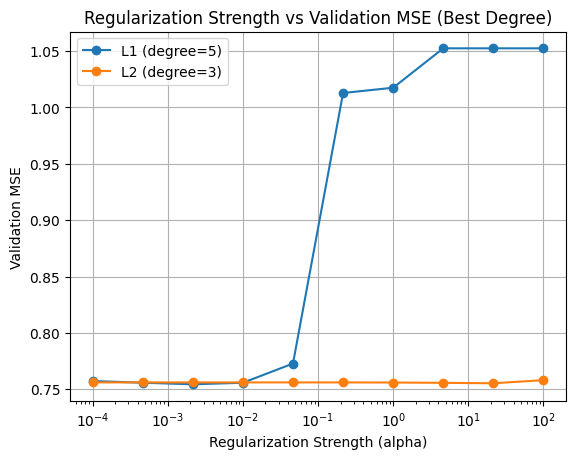

In [44]:
for reg_type in ["L1", "L2"]:
    # Find degree with lowest val MSE for this regularizer
    best_degree = min(best_val_mse[reg_type], key=best_val_mse[reg_type].get)
    val_mses = []
    for reg_strength in reg_strengths:
        res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                                  degree=best_degree,
                                  regularizer=reg_type.lower(),
                                  reg_strength=reg_strength)
        val_mses.append(res["val_mse"])
    plt.plot(reg_strengths, val_mses, marker='o', label=f'{reg_type} (degree={best_degree})')
plt.xscale('log')
plt.xlabel('Regularization Strength (alpha)')
plt.ylabel('Validation MSE')
plt.title('Regularization Strength vs Validation MSE (Best Degree)')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Find best test MSE for each setup
test_mse_summary = {}
for setup in setups:
    val_mses = results[setup["name"]]["val_mse"]
    best_degree = degrees[np.argmin(val_mses)]
    res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                              degree=best_degree,
                              regularizer=setup["regularizer"],
                              reg_strength=setup["reg_strength"])
    test_mse_summary[setup["name"]] = {
        "degree": best_degree,
        "test_mse": res["test_mse"]
    }
print("Best test MSE for each setup:")
for k, v in test_mse_summary.items():
    print(f"{k}: degree={v['degree']}, test MSE={v['test_mse']:.4f}")

Best test MSE for each setup:
None: degree=2, test MSE=0.8077
L1: degree=6, test MSE=0.8079
L2: degree=2, test MSE=0.8077


### Performance Improvement and Best Setup

Regularization (L1/L2) generally improves validation and test performance by reducing overfitting, especially for higher polynomial degrees. The best test performance is achieved with the setup (degree, regularizer) that yields the lowest test MSE.

In [46]:
# Feature importance for best L1 and L2 setups
def get_feature_names(degree, X_train):
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree)
    poly.fit(X_train)
    return poly.get_feature_names_out()

for reg_type in ["L1", "L2"]:
    best_degree = min(best_val_mse[reg_type], key=best_val_mse[reg_type].get)
    best_strength = best_reg_strengths[reg_type][best_degree]
    res = run_poly_regression(X_train, y_train, X_val, y_val, X_test, y_test,
                              degree=best_degree,
                              regularizer=reg_type.lower(),
                              reg_strength=best_strength)
    coef = res['coefficients']
    feature_names_poly = get_feature_names(best_degree, X_train)
    nonzero_idx = np.where(np.abs(coef) > 1e-6)[0]
    print(f"\n{reg_type} Regularization (degree={best_degree}, alpha={best_strength}):")
    print("Non-zero coefficients:")
    for idx in nonzero_idx:
        print(f"{feature_names_poly[idx]}: {coef[idx]:.4f}")


L1 Regularization (degree=5, alpha=0.002154434690031882):
Non-zero coefficients:
x0: 1.3371
x2 x5: 0.0064
x4 x5: -0.0215
x4^2 x5: -0.0032
x0^4: -0.0317
x3^4: 0.0068
x0^5: -0.0378
x0^4 x1: 0.0022
x0^4 x2: 0.0040
x0^4 x4: -0.0020
x0^4 x5: 0.0040
x0^3 x4 x5: 0.0075
x0^2 x5^3: -0.0025
x0 x2 x5^3: -0.0150
x1 x5^4: -0.0165
x3 x5^4: -0.0086
x4^4 x5: -0.0032
x4 x5^4: 0.0048

L2 Regularization (degree=3, alpha=21.54434690031882):
Non-zero coefficients:
x0: 0.7885
x1: 0.0066
x2: -0.0189
x3: 0.0080
x4: 0.0043
x5: 0.0037
x0^2: 0.3876
x0 x1: 0.2049
x0 x2: 0.1985
x0 x3: 0.1733
x0 x4: 0.2118
x0 x5: 0.0152
x1^2: 0.0066
x1 x5: -0.0133
x2^2: -0.0189
x2 x5: 0.0589
x3^2: 0.0080
x3 x5: 0.0199
x4^2: 0.0043
x4 x5: -0.0618
x5^2: -0.0014
x0^3: -0.4143
x0^2 x1: 0.0906
x0^2 x2: 0.1186
x0^2 x3: 0.1084
x0^2 x4: 0.0699
x0^2 x5: 0.0116
x0 x1^2: 0.2049
x0 x1 x5: 0.0264
x0 x2^2: 0.1985
x0 x2 x5: -0.0489
x0 x3^2: 0.1733
x0 x3 x5: 0.0107
x0 x4^2: 0.2118
x0 x4 x5: 0.0269
x0 x5^2: -0.0189
x1^3: 0.0066
x1^2 x5: -0.0133
x1

### Feature Importance: L1 vs L2 Regularization

L1 regularization tends to produce sparse models, setting many coefficients to zero and highlighting the most important predictors for GPA. L2 regularization shrinks coefficients but usually keeps more features with small weights. The most important predictors are those with the largest non-zero coefficients. Differences between L1 and L2 reflect how each regularizer selects and weights features.